# Homework 4: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information Health Engineering, 2019-2020*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).



> DUDAS PARA PREGUNTAR:


1.   KERNELS distintos para cada modelo?
2.   Optimización de restart o a secas
3.   Fijar constraints? (priors)
4.   MSE y MAE con todos los datos?






### 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 
* Normalize data if needed

In [0]:
from google.colab import files
import pandas as pd
import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings
from IPython.display import display
import sklearn.metrics as metrics

warnings.filterwarnings('ignore')


In [2]:
uploaded = files.upload()

# lo cargamos en un dataframe de pandas
df = pd.read_csv(io.BytesIO(uploaded['HW4_data_csv.csv']))

# borramos las dos ultimas columnas
df.__delitem__('Unnamed: 10')
df.__delitem__('Unnamed: 11')
print(df)

"""
Specifically:
X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution
y1 Heating Load
y2 Cooling Load

"""


Saving HW4_data_csv.csv to HW4_data_csv.csv
       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


'\nSpecifically:\nX1 Relative Compactness\nX2 Surface Area\nX3 Wall Area\nX4 Roof Area\nX5 Overall Height\nX6 Orientation\nX7 Glazing Area\nX8 Glazing Area Distribution\ny1 Heating Load\ny2 Cooling Load\n\n'

In [3]:
# convertimos a array de numpy
data = pd.DataFrame(df).to_numpy()
print(f"\n Tamanio datos: \n{data.shape}")
#print(data)


 Tamanio datos: 
(768, 10)


In [4]:
# dividimos el dataset

X = data[:,0:8]
Y = data[:,8:10]

X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(f"\n Tamanio datos test: \n{y_test.shape}")

# Normalizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\n Transformador de datos con media 0 y varianza 1: \n{scaler}")

print(f"\n Datos normalizados media: \n {X_train.mean(axis=0)}")
print(f"\n Datos normalizados varianza: \n {X_train.std(axis=0)}")


 Tamanio datos test: 
(154, 2)

 Transformador de datos con media 0 y varianza 1: 
StandardScaler(copy=True, with_mean=True, with_std=True)

 Datos normalizados media: 
 [-2.58407121e-15 -1.71415542e-16 -6.16864419e-16  2.82980299e-16
 -5.06290630e-18 -1.92390439e-16 -3.08837284e-16 -5.27988800e-17]

 Datos normalizados varianza: 
 [1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# # dividimos la variable objetivo en dos
# y_train_HL = Y_train[:,0]
# y_train_CL = Y_train[:,1]
# y_test_HL = y_test[:,0]
# y_test_CL = y_test[:,1]

In [0]:
# # Set up our plotting environment
# plt.figure(figsize=(14, 8))

# # Plot the training data in blue and the test data in red
# plt.plot(X_train[:, 1], Y_train[:, :1], "b.", X_test[:, 1], y_test[:, :1], "r.")

# plt.show()

### 2. Setting and optimizing the model

You will train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs ...

**On the training data set:**

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term. 

b) Fit the covariance function parameters and noise variance. 

c) According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) 

**On the test data set:**

d) Compute the test mean absolute error error and the test mean square error (MSE)  using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X).


2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define different kernels and combine  them. Comments the results. 



In [7]:
# You can also install GPy using the following command (Works on Windows!)

!pip install GPy 

     |████████████████████████████████| 1.0MB 5.1MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633975 sha256=46ba7d4ff71396e2ca9ee84da9c147bea3eb5ad818ce9f0cc53dc8d5ff568ed8
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=252306be4a0f3f7a065a3bdeff0ff29d2b622bef2422db037a4c50f761827f9e
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
import GPy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

# Plot random values

In [0]:
# seleccionar una serie de puntos aleatorios de X
n = 20  
index = np.random.choice(X_train.shape[0], n, replace=False) 

x_random = X[index]
y_random = Y[index]

# selecionandoo puntos aleatorios de una columna

columna = 7
X_new=X[:,columna]
#print("\n Tamanio X_new: \n",X_new.shape)
Y_new_HL=Y[:,0]
##print("\n Tamanio Y_new_HL: \n",Y_new_HL.shape)
Y_new_CL=Y[:,1]
##print("\n Tamanio Y_new_CL: \n",Y_new_CL.shape)

#print("\n X: \n",X)
#print("\n Y_new_HL: \n",Y_new_HL)
#print("\n Y_new_CL: \n",Y_new_CL)

X_new = X_new[index]
Y_new_HL=Y_new_HL[index]
Y_new_CL=Y_new_CL[index]

Text(0, 0.5, '$Y$')

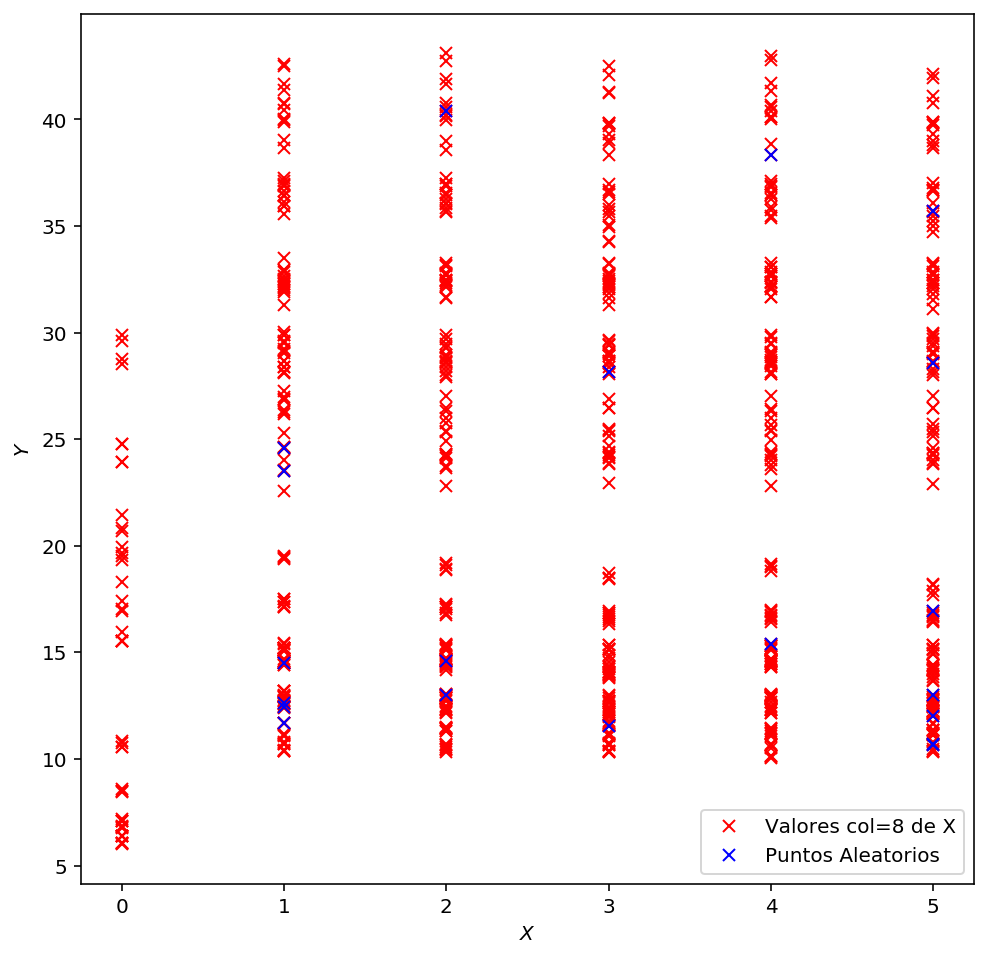

In [10]:
#graficamos los puntos aleatorios
plt.figure()
plt.plot(X[:,columna],Y[:,0],'rx')
plt.plot(X_new,Y_new_HL,'bx',ms=6)
plt.legend(['Valores col='+str(columna+1)+' de X','Puntos Aleatorios'])
plt.xlabel('$X$')
plt.ylabel('$Y$')
#plt.xlim([-1,1])

In [0]:
# X_train_1 = X_train[:,:2]
# Y_train_1 = Y_train[:,:0]

#X_train_1 = X_train_1[:, np.newaxis]
#Y_train_1 = Y_train_1[:, np.newaxis]

#print(X_train_1.shape)
#print(Y_train_1.shape)
#print(X_train_1)
#print(Y_train_1)



---




We will train **two independent GPs** one to estimate HL and one to estimate CL. 

# Part 1 - The ''m_HL'' model 
## 1.1 On the training data set: 
***First***, built a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term.

**KERNEL**

In [12]:
kernel = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True) + GPy.kern.White(input_dim=X_train.shape[1])
print(kernel)

  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |   (8,)  |      +ve      |        
  white.variance   |    1.0  |      +ve      |        


**Values at the beginning**

In [13]:
print(f"\n Parametros del Kernel: \n {kernel.parameter_names()}")
print(f"\n Valores de la varianza para kernel=RBF: \n {kernel.rbf.variance.values}")
print(f"\n Valores del parametro 'lengthscale' para kernel=RBF: \n {kernel.rbf.lengthscale.values}")
print(f"\n Valores del parametro varianza del ruido blanco: \n {kernel.white.variance.values}")


 Parametros del Kernel: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Valores de la varianza para kernel=RBF: 
 [1.]

 Valores del parametro 'lengthscale' para kernel=RBF: 
 [1. 1. 1. 1. 1. 1. 1. 1.]

 Valores del parametro varianza del ruido blanco: 
 [1.]


We will have an lenghtscale array with eight elements as we have one possible value per input dimension. At the beginning, we will have the values initialized to 1. After the optimization, the lenghtscale values will adjust to the data.

***Secondly***, fit the covariance function (KERNEL) parameters and noise variance.

**MODEL**

In [0]:
m_HL = GPy.models.GPRegression(X_train,Y_train[:, :1],kernel)

This model is initialized with incorrect lengthscale and variance, so let's optimize it.



> Due to the lack of information a priori about the data we have, it is not possible to fix any constraints



In [0]:
## EXAMPLES OF POSIBLE CONSTRAINTS, PREGUNTAR!
# m_HL.constrain_bounded('rbf_var',1e-3,1e5)
# m_HL.constrain_bounded('bias_var',1e-3,1e5)
# m_HL.constrain_bounded('rbf_len',.1,200.)
# m_HL.constrain_fixed('noise',1e-5)

**OPTIMIZATION**

In [16]:
# # OPTIMIZE_RESTARTS comienza desde el inicio la optimizacion: puede que en el utlimo restart no haga una buena optimizacion
# COGE EL VALOR DE OPTIMIZACION MENOR, no es muy bueno??
print('Regression Model before optimization:')
print (m_HL)
print("")

# print("\n Optimizacion para variable de salida HL: \n")
print(m_HL.optimize_restarts(num_restarts = 15))

print("")
print('Regression Model after optimization:')
print (m_HL)

Regression Model before optimization:

Name : GP regression
Objective : 11345.879287055062
Number of Parameters : 11
Number of Optimization Parameters : 11
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  sum.rbf.variance         |    1.0  |      +ve      |        
  sum.rbf.lengthscale      |   (8,)  |      +ve      |        
  sum.white.variance       |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        

Optimization restart 1/15, f = 748.2161333374574
Optimization restart 2/15, f = 513.4803477452078
Optimization restart 3/15, f = 524.8548901942152
Optimization restart 4/15, f = 512.5303049394236
Optimization restart 5/15, f = 519.0600081506036
Optimization restart 6/15, f = 576.7253976427354
Optimization restart 7/15, f = 512.1203831578736
Optimization restart 8/15, f = 514.203294751075
Optimization restart 9/15, f = 515.1903729190124
Optimization restart 10/15, f = 711.7215627828756
Optimizatio

In [0]:
# print('Before optimization')
# print (m_HL, '\n')
# for i in range(10):
#     m_HL.optimize(max_iters=100) #first runs EP (KERNEL) and then optimizes the kernel parameters
#     print('Iteration:', i)
# print('After optimization')
# print (m_HL, '\n')

Now our parameters have been optimised to the values that give the largest marginal likelihood.

**Values at the end**

In [18]:
print(f"\n Parametros del Kernel: \n {kernel.parameter_names()}")
print(f"\n Valores de la varianza para kernel=RBF: \n {kernel.rbf.variance.values}")
print(f"\n Valores del parametro 'lengthscale' para kernel=RBF: \n {kernel.rbf.lengthscale.values}")
print(f"\n Valores del parametro varianza del ruido blanco: \n {kernel.white.variance.values}")


 Parametros del Kernel: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Valores de la varianza para kernel=RBF: 
 [1839.34407011]

 Valores del parametro 'lengthscale' para kernel=RBF: 
 [  1.58899402   0.94893317   4.98446593 745.81549349   2.60200163
 902.57909795   3.14026212 306.41417343]

 Valores del parametro varianza del ruido blanco: 
 [0.18487068]


***Third***, According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the paper

BUSCADO EN INTERNET: *The length scale merely determines the idea of how close two data points are in a particular input dimension not how useful they are. 
If you want to figure out an importance of each feature first look at your kernel and decompose it by removing one dimension of x (i.e. remove a feature). Then determine the variance over you prediction space. Repeat for each dimension. **How 'important' a feature is can be see as how much it reduces the variance on predictions**.* 
**PREGUNTAR A PABLO SI ESTO ES LO QUE QUIERE!**

**The lenght scale and the importance of a feature is not directly related.** However, it can be assumed that hyper parameters can tell something about the importance about the feature. If the hyper parameter of a certain feature is small, only a small change in that feature would cause very different output value. Assuming that we take this input feature out from the input vector, the variance of the model would increase (or prediction accuracy decrease a lot). 


In [19]:
print(kernel.rbf.lengthscale)

  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |  priors
  [0]    |                         1.58899402  |      +ve      |        
  [1]    |                         0.94893317  |      +ve      |        
  [2]    |                         4.98446593  |      +ve      |        
  [3]    |                       745.81549349  |      +ve      |        
  [4]    |                         2.60200163  |      +ve      |        
  [5]    |                       902.57909795  |      +ve      |        
  [6]    |                         3.14026212  |      +ve      |        
  [7]    |                       306.41417343  |      +ve      |        




> PAPER - TABLE 8 : *the importance results in Table 8 suggest that X7 (glazing
area) is the most important predictor for both HL and CL.*



According to what we mentioned, if we look at the table the most relevant features are the following ones: 

*   X7 Glazing Area
*   X1 Relative Compactness
*   X3 Wall Area


## 1.2 On the test data set

***Firslty***, Compute the test mean absolute error (MAE) and the test mean square error (MSE) using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the paper.


In [20]:
nsamples= X_train.shape[0]

## PREDICTION

## CON TODOS LOS DATOS
# Xnew = np.vstack([X_train, X_test])
# Y_pred_mean, Cov= m_HL.predict(Xnew,full_cov=True) #Y_pred_mean is the posterior mean

## SOLO CON LOS DATOS DE TEST
Y_pred_mean, Cov= m_HL.predict(X_test, full_cov=True)

## NO BORRAR -- PREGUNTAR
# Samples the posterior GP at the points X_test
# posteriorYtest = m_HL.posterior_samples_f(X_test, full_cov=True, size=nsamples)


## METRICS

## CON TODOS LOS DATOS
# Ynew = np.vstack([Y_train[:, :1], y_test[:, :1]])
# MSE= metrics.mean_squared_error(Ynew, Y_pred_mean)
# MAE= metrics.mean_absolute_error(Ynew, Y_pred_mean)

## CON LOS DATOS DE TEST
MSE= metrics.mean_squared_error(y_test[:, :1], Y_pred_mean)
MAE= metrics.mean_absolute_error(y_test[:, :1], Y_pred_mean)

print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 0.2786889286198719
The MAE is: 0.36282556123387366




> PAPER -  TABLE 5 and TABLE 5:  

*   MSE: 9.87 ± 2.41 (IRIS classifier) 1.03 ± 0.54 (RF classifier)
*   MAE: 2.14 ± 0.24 (IRIS classifier) 0.51 ± 0.11 (RF classifier)

The results are given in the form mean ± standard deviation.



***Secondly***, Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this link you can see how to define different kernels and combine them. Comments the results.



> ESCOGER: he puesto mazo, al fianl podriamos coger solo los dos mejores y los dos peores


In [0]:
## KERNELS
k1 = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
k2 = GPy.kern.Matern32(input_dim=X_train.shape[1], ARD=True)
k3 = GPy.kern.Linear(input_dim=X_train.shape[1], ARD=True) 
k4 = GPy.kern.ExpQuad(input_dim=X_train.shape[1], ARD=True) 

## OPERATION OVER KERNELS
# Sum of kernels
k_add_1 = k1 + k2
k_add_2 = k1 + k3
k_add_3 = k1 + k4

# Product of kernels
k_prod_1 = k1 *k2
k_prod_2 = k1 *k3
k_prod_3 = k1 *k4

In [0]:
m_HL_k1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k1)
m_HL_k2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k2)
m_HL_k3 = GPy.models.GPRegression(X_train,Y_train[:, :1],k3)
m_HL_k4 = GPy.models.GPRegression(X_train,Y_train[:, :1],k4)

m_HL_k_add_1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_add_1)
m_HL_k_add_2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_add_2)
m_HL_k_add_3 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_add_3)

m_HL_k_prod_1 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_prod_1)
m_HL_k_prod_2 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_prod_2)
m_HL_k_prod_3 = GPy.models.GPRegression(X_train,Y_train[:, :1],k_prod_3)



> TARDA LA VIDA



In [23]:
print('Init')

m_HL_k1.optimize_restarts(num_restarts = 5)
m_HL_k2.optimize_restarts(num_restarts = 5)
m_HL_k3.optimize_restarts(num_restarts = 5)
m_HL_k4.optimize_restarts(num_restarts = 5)

m_HL_k_add_1.optimize_restarts(num_restarts = 5)
m_HL_k_add_2.optimize_restarts(num_restarts = 5)
m_HL_k_add_3.optimize_restarts(num_restarts = 5)

m_HL_k_prod_1.optimize_restarts(num_restarts = 5)
m_HL_k_prod_2.optimize_restarts(num_restarts = 5)
m_HL_k_prod_3.optimize_restarts(num_restarts = 5)

print('End')

Init
Optimization restart 1/5, f = 639.6362262577159
Optimization restart 2/5, f = 521.4859296895338
Optimization restart 3/5, f = 1064.2055038566468
Optimization restart 4/5, f = 514.8208418965967
Optimization restart 5/5, f = 706.3840463074579
Optimization restart 1/5, f = 511.5019917914012
Optimization restart 2/5, f = 511.4982943018597
Optimization restart 3/5, f = 511.4957530249909
Optimization restart 4/5, f = 511.4989768083944
Optimization restart 5/5, f = 505.4069712291832
Optimization restart 1/5, f = 2785.108994449356
Optimization restart 2/5, f = 2785.108974285052
Optimization restart 3/5, f = 2785.1089385654486
Optimization restart 4/5, f = 2785.1089786674365
Optimization restart 5/5, f = 2785.10896621756
Optimization restart 1/5, f = 639.6362262577159
Optimization restart 2/5, f = 522.6426573338686
Optimization restart 3/5, f = 1194.4768999753614
Optimization restart 4/5, f = 560.3218465889834
Optimization restart 5/5, f = 621.6372239248002
Optimization restart 1/5, f = 41

In [0]:
nsamples= X_train.shape[0]
models= [m_HL_k1, m_HL_k2, m_HL_k3, m_HL_k4, m_HL_k_add_1, m_HL_k_add_2, m_HL_k_add_3, m_HL_k_prod_1, m_HL_k_prod_2, m_HL_k_prod_3]

MSE= []
MAE= []

for model in models:
    Y_pred_mean, Cov= model.predict(X_test, full_cov=True)
    MSE.append(metrics.mean_squared_error(y_test[:, :1], Y_pred_mean))
    MAE.append(metrics.mean_absolute_error(y_test[:, :1], Y_pred_mean))



> TAMBIEN SERIA UTIL DECIR LOS TRES LENGTHSCALE MAS BAJOS SEGUN CADA KERNEL



In [25]:
models0= ['RBF',' Matern32', 'Linear', 'ExpQuad', 'RBF + Matern32', 'RBF + Linear', 'RBF + ExpQuad', 'RBF x Matern32',' RBF x Linear', 'RBF x ExpQuad']
dataframe=pd.DataFrame(models0, columns=['Models'])
dataframe['MSE']= np.asarray(MSE).ravel()
dataframe['MAE']= np.asarray(MAE).ravel()
dataframe.head(10)

,Models,MSE,MAE
0,RBF,0.278978,0.362944
1,Matern32,0.190885,0.277200
2,Linear,511.337284,22.348718
3,ExpQuad,0.279355,0.363349
4,RBF + Matern32,0.216029,0.289943
5,RBF + Linear,0.278552,0.360822
6,RBF + ExpQuad,0.188498,0.262135
7,RBF x Matern32,0.233338,0.308754
8,RBF x Linear,0.299041,0.365175
9,RBF x ExpQuad,0.278021,0.359038



---

# Part 2 - The ''m_CL'' model
## 2.1 On the training data set
***First***, built a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term.

**KERNEL**

In [26]:
kernel_1 = GPy.kern.RBF(input_dim=X_train.shape[1],ARD=True) + GPy.kern.White(input_dim=X_train.shape[1])
print(kernel_1)

  sum.             |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |   (8,)  |      +ve      |        
  white.variance   |    1.0  |      +ve      |        


**Values at the beginning**

In [27]:
print(f"\n Parametros del Kernel: \n {kernel_1.parameter_names()}")
print(f"\n Valores de la varianza para kernel=RBF: \n {kernel_1.rbf.variance.values}")
print(f"\n Valores del parametro 'lengthscale' para kernel=RBF: \n {kernel_1.rbf.lengthscale.values}")
print(f"\n Valores del parametro varianza del ruido blanco: \n {kernel_1.white.variance.values}")


 Parametros del Kernel: 
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

 Valores de la varianza para kernel=RBF: 
 [1.]

 Valores del parametro 'lengthscale' para kernel=RBF: 
 [1. 1. 1. 1. 1. 1. 1. 1.]

 Valores del parametro varianza del ruido blanco: 
 [1.]


***Secondly***, fit the covariance function parameters and noise variance.

**MODEL**

In [0]:
m_CL = GPy.models.GPRegression(X_train,Y_train[:, 1:],kernel_1)

**OPTIMIZATION**

In [29]:
# # OPTIMIZE_RESTARTS comienza desde el inicio la optimizacion: puede que en el utlimo restart no haga una buena optimizacion
# COGE EL VALOR DE OPTIMIZACION MENOR, no es muy bueno??
print('Regression Model before optimization:')
print (m_HL)
print("")

# print("\n Optimizacion para variable de salida HL: \n")
print(m_HL.optimize_restarts(num_restarts = 15))

print("")
print('Regression Model after optimization:')
print (m_HL)

Regression Model before optimization:

Name : GP regression
Objective : 512.1203831578736
Number of Parameters : 11
Number of Optimization Parameters : 11
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  sum.rbf.variance         |      1839.344070110414  |      +ve      |        
  sum.rbf.lengthscale      |                   (8,)  |      +ve      |        
  sum.white.variance       |    0.18487068221327635  |      +ve      |        
  Gaussian_noise.variance  |  3.361433770705662e-47  |      +ve      |        

Optimization restart 1/15, f = 512.1203829058916
Optimization restart 2/15, f = 519.0888955885771
Optimization restart 3/15, f = 594.0654633128496
Optimization restart 4/15, f = 537.856974755741
Optimization restart 5/15, f = 506.88194577575933
Optimization restart 6/15, f = 521.6219803619601
Optimization restart 7/15, f = 512.5074161125958
Optimization restart 8/15, f = 521.3390676693846
Optimization restart 9/15, f =

**Values at the end**

In [0]:
# print(f"\n Parametros del Kernel: \n {kernel_1.parameter_names()}")
# print(f"\n Valores de la varianza para kernel=RBF: \n {kernel_1.rbf.variance.values}")
# print(f"\n Valores del parametro 'lengthscale' para kernel=RBF: \n {kernel_1.rbf.lengthscale.values}")
# print(f"\n Valores del parametro varianza del ruido blanco: \n {kernel_1.white.variance.values}")

***Third***, According to the ARD parameters found, what variables are more important for the regression?


In [31]:
print(kernel_1.rbf.lengthscale)

  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |  priors
  [0]    |                         1.00000000  |      +ve      |        
  [1]    |                         1.00000000  |      +ve      |        
  [2]    |                         1.00000000  |      +ve      |        
  [3]    |                         1.00000000  |      +ve      |        
  [4]    |                         1.00000000  |      +ve      |        
  [5]    |                         1.00000000  |      +ve      |        
  [6]    |                         1.00000000  |      +ve      |        
  [7]    |                         1.00000000  |      +ve      |        




> PAPER - TABLE 8 : *the importance results in Table 8 suggest that X7 (glazing
area) is the most important predictor for both HL and CL.*



According to what we mentioned, if we look at the table the most relevant features are the following ones: 

*   X1 Relative Compactness
*   X3 Wall Area


## 2.2. On the test data set

***Firstlty***, Compute the test mean absolute error error and the test mean square error (MSE) using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the paper.

In [32]:
## PREDICTION
nsamples= X_train.shape[0]

## CON TODOS LOS DATOS
# Xnew = np.vstack([X_train, X_test])
# mean, Cov= m_HL.predict(Xnew,full_cov=True) #mean_test is the posterior mean

## CON LOS DATOS DE TEST
mean, Cov= m_CL.predict(X_test,full_cov=True)

## NO BORRAR -- PREGUNTAR
# Samples the posterior GP at the points X_test
# posteriorYtest = m_HL.posterior_samples_f(X_test, full_cov=True, size=nsamples)

## METRICS
## CON TODOS LOS DATOS
# Ynew = np.vstack([Y_train[:, 1:], y_test[:, 1:]])
# MSE= metrics.mean_squared_error(Ynew, mean)
# MAE= metrics.mean_absolute_error(Ynew, mean)

## CON LOS DATOS DE TEST
MSE= metrics.mean_squared_error(y_test[:, 1:], mean)
MAE= metrics.mean_absolute_error(y_test[:, 1:], mean)

print('The MSE is:', MSE)
print('The MAE is:', MAE)

The MSE is: 32.609890640211965
The MAE is: 4.216849114582263




> PAPER -  TABLE 5 and TABLE 5:  

*   MSE: 11.46 ± 3.63 (IRIS classifier) 6.59 ± 1.56 (RF classifier)
*   MAE: 2.21 ± 0.28 (IRIS classifier) 1.42 ± 0.25 (RF classifier)

The results are given in the form mean ± standard deviation.



***Secondly***, Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this link you can see how to define different kernels and combine them. Comments the results.

In [0]:
## KERNELS
k1 = GPy.kern.RBF(input_dim=X_train.shape[1], ARD=True)
k2 = GPy.kern.Matern32(input_dim=X_train.shape[1], ARD=True)
k3 = GPy.kern.Linear(input_dim=X_train.shape[1], ARD=True) 
k4 = GPy.kern.ExpQuad(input_dim=X_train.shape[1], ARD=True) 

## OPERATION OVER KERNELS
# Sum of kernels
k_add_1 = k1 + k2
k_add_2 = k1 + k3
k_add_3 = k1 + k4

# Product of kernels
k_prod_1 = k1 *k2
k_prod_2 = k1 *k3
k_prod_3 = k1 *k4

In [0]:
m_HL_k1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k1)
m_HL_k2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k2)
m_HL_k3 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k3)
m_HL_k4 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k4)

m_HL_k_add_1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_add_1)
m_HL_k_add_2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_add_2)
m_HL_k_add_3 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_add_3)

m_HL_k_prod_1 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_prod_1)
m_HL_k_prod_2 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_prod_2)
m_HL_k_prod_3 = GPy.models.GPRegression(X_train,Y_train[:, 1:],k_prod_3)

In [35]:
print('Init')

m_HL_k1.optimize_restarts(num_restarts = 5)
m_HL_k2.optimize_restarts(num_restarts = 5)
m_HL_k3.optimize_restarts(num_restarts = 5)
m_HL_k4.optimize_restarts(num_restarts = 5)

m_HL_k_add_1.optimize_restarts(num_restarts = 5)
m_HL_k_add_2.optimize_restarts(num_restarts = 5)
m_HL_k_add_3.optimize_restarts(num_restarts = 5)

m_HL_k_prod_1.optimize_restarts(num_restarts = 5)
m_HL_k_prod_2.optimize_restarts(num_restarts = 5)
m_HL_k_prod_3.optimize_restarts(num_restarts = 5)

print('End')

Init
Optimization restart 1/5, f = 1227.8907069411248
Optimization restart 2/5, f = 1227.4832753615792
Optimization restart 3/5, f = 1231.4268719351467
Optimization restart 4/5, f = 1229.4386540687926
Optimization restart 5/5, f = 1232.026984055452
Optimization restart 1/5, f = 927.4898105520656
Optimization restart 2/5, f = 927.4894152475197
Optimization restart 3/5, f = 932.0714983578557
Optimization restart 4/5, f = 927.4902001671843
Optimization restart 5/5, f = 932.0723531057861
Optimization restart 1/5, f = 2845.9138794044966
Optimization restart 2/5, f = 2846.0918374210178
Optimization restart 3/5, f = 2845.9138687321283
Optimization restart 4/5, f = 2845.9138779905734
Optimization restart 5/5, f = 2846.091827128753
Optimization restart 1/5, f = 1227.8907069411248
Optimization restart 2/5, f = 1232.3590416953325
Optimization restart 3/5, f = 1227.6889800413112
Optimization restart 4/5, f = 1228.1762259151049
Optimization restart 5/5, f = 1228.1783988989846
Optimization restart 1

In [0]:
nsamples= X_train.shape[0]
models= [m_HL_k1, m_HL_k2, m_HL_k3, m_HL_k4, m_HL_k_add_1, m_HL_k_add_2, m_HL_k_add_3, m_HL_k_prod_1, m_HL_k_prod_2, m_HL_k_prod_3]

MSE= []
MAE= []

for model in models:
    Y_pred_mean, Cov= model.predict(X_test, full_cov=True)
    MSE.append(metrics.mean_squared_error(y_test[:, 1:], Y_pred_mean))
    MAE.append(metrics.mean_absolute_error(y_test[:, 1:], Y_pred_mean))



> TAMBIEN SERIA UTIL DECIR LOS TRES LENGTHSCALE MAS BAJOS SEGUN CADA KERNEL



In [37]:
models0= ['RBF',' Matern32', 'Linear', 'ExpQuad', 'RBF + Matern32', 'RBF + Linear', 'RBF + ExpQuad', 'RBF x Matern32',' RBF x Linear', 'RBF x ExpQuad']
dataframe=pd.DataFrame(models0, columns=['Models'])
dataframe['MSE']= np.asarray(MSE).ravel()
dataframe['MAE']= np.asarray(MAE).ravel()
dataframe.head(10)

,Models,MSE,MAE
0,RBF,3.358964,1.220274
1,Matern32,0.299490,0.404503
2,Linear,605.193587,24.346979
3,ExpQuad,3.378337,1.225102
4,RBF + Matern32,0.176133,0.251196
5,RBF + Linear,3.466191,1.247059
6,RBF + ExpQuad,0.321307,0.416040
7,RBF x Matern32,0.281626,0.396358
8,RBF x Linear,0.424739,0.472751
9,RBF x ExpQuad,0.464881,0.492575


# Part 3 - Sparse GP implementation 

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points. 

In [0]:
#Your code here

# Comments

ARD: estimating the lengthscale parameters
`l1, `l2, ··· , `lD implicitly determines the relevance of each dimension. Take into account
that input dimensions with relatively large lengthscales imply relatively little variation
along those dimensions in the function being modeled.


https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/multiple%20outputs.ipynb

https://nbviewer.jupyter.org/url/gpss.cc/gpss18/labs/GPSS_Lab1_2018_Answers.ipynb

https://thegradient.pub/gaussian-process-not-quite-for-dummies/

http://gpss.cc/gprs15b/assets/session1.pdf

Vertical scale (VARAINCE): describes how much span the function has vertically;
Horizontal scale (LENGHTSCALE): describes how quickly the correlation between two points drops as the distance between them increases -- a high l gives you a smooth function, while lower l results in a wiggly function.